In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter
from torch.autograd import Variable
from torch.optim import Adam
from nilearn import plotting
import nibabel as nib
import nilearn
from sklearn.metrics import accuracy_score
from mri_model import MriNet
from mri_model import MriData
from sklearn.model_selection import  StratifiedKFold
%matplotlib inline

In [2]:
X, y = np.load('E:/Target_and_data/tensors.npy'), np.load('E:/Target_and_data/labels.npy')#change path 
X = X[:,None,:,:,:]
print(X.shape, y.shape)
brain_mask = np.load('E:/Target_and_data/masks_brain.npy')#change path
brain_mask = brain_mask[:,None,:,:,:]
print(brain_mask.shape)

(1113, 1, 58, 70, 58) (1113,)
(1113, 1, 58, 70, 58)


In [3]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target,out,pred
    accuracy = 100. * correct / len(data_loader.dataset)
    del correct
    return accuracy.item()
    del accuracy
    
def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out 

    return loss / len(data_loader.dataset)
    del loss
def get_prediction(net, data_loader):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False):
    best_val_loss = 100_000
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    train_loss_list.append(get_loss(net, train_loader))
    val_loss_list.append(get_loss(net, val_loader))
    train_acc_list.append(get_accuracy(net, train_loader))
    val_acc_list.append(get_accuracy(net, val_loader))
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            del X, y, out, loss #freeing gpu space
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, y in val_loader:
            # Compute the validation loss
            X, y = X.to(device), y.to(device)
            out = net(X)
            del X, y, out #freeing gpu space
         
        if scheduler is not None:
            scheduler.step()
        
        
        train_loss_list.append(get_loss(net, train_loader))
        val_loss_list.append(get_loss(net, val_loader))
        train_acc_list.append(get_accuracy(net, train_loader))
        val_acc_list.append(get_accuracy(net, val_loader))

        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR+'best_model')
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1]))
        
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list
            
            

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
torch.manual_seed(1)
np.random.seed(1)
c = 32

In [5]:
dataset = MriData(X,y)
loader = torch.utils.data.DataLoader(dataset, batch_size=46, shuffle=False)
net = MriNet(c).to(device)
net.load_state_dict(torch.load('E:/Target_and_data/best_model_k', map_location=device))#change path
net = net.float()
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [6]:
torch.cuda.empty_cache()

In [7]:
pred = np.concatenate(get_prediction(net,loader),axis=0)
print(accuracy_score(y,pred))
del dataset,loader

0.9299191374663073


In [8]:
def jittering(img,jit,C,D,H,W) :
    return np.resize(img,(C,D+jit,H+jit,W+jit))
def upsample(mask, img_size):
    x = F.interpolate(mask, size=img_size, mode='trilinear', align_corners=False)
    return x
    del x
def np_to_torch(X,device,img_size,requires_grad = False):
    output = torch.from_numpy(X).to(device).reshape(img_size)
    return  Variable(output, requires_grad = requires_grad)
    del output
def tv_norm(x, beta = 1):
    d1 = torch.mean(torch.abs(x[:,:,:-1,:,:]-x[:,:,1:,:,:]).pow(beta))
    d2 = torch.mean(torch.abs(x[:,:,:,:-1,:]-x[:,:,:,1:,:]).pow(beta))
    d3 = torch.mean(torch.abs(x[:,:,:,:,:-1]-x[:,:,:,:,1:]).pow(beta))
    tv =  d1+d2+d3
    del d1,d2,d3
    return tv
class GaussianFilter(nn.Module):
    def __init__(self, k_size, device, g_filter):
        super(GaussianFilter, self).__init__()
        pad = (k_size-1)//2
        self.k_size = k_size
        self.conv =  nn.Conv3d(1, 1, k_size,padding=(pad,pad,pad), bias=None)
        self.conv.to(device)
        self.g_filter = g_filter
    def forward(self, x,sigma):
        n= np.zeros((self.k_size,self.k_size,self.k_size))
        n[self.k_size//2+1,self.k_size//2+1,self.k_size//2+1] = 1
        k = self.g_filter(n,sigma=sigma)[None,None,:,:,:]
        self.conv.weight = torch.nn.Parameter(torch.from_numpy(k).float().to(device))
        for param in self.conv.parameters():
            param.requires_grad = False
        return self.conv(x)

In [7]:
N, C, D, H, W = X.shape
mask_scale = 4
blur_sigma_img = 10
blur_sigma_mask = 10
max_iter = 300
rw_max = max_iter//5
l1_coeff = 12
tv_coeff = 5
tv_beta = 7
repetition_general = 10
jit = 5
filter_gaus = GaussianFilter(5,device,gaussian_filter)

res = []
for i,img in enumerate(X[:2]):
    model_ans = pred[i]
    mask = torch.ones((1, C, D // mask_scale, H // mask_scale, W // mask_scale)).to(device)
    mask = Variable(mask,requires_grad=True)
    optimizer = Adam([mask],0.3, betas=(0.9, 0.99), amsgrad=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    best_loss, best_mask = float('inf'), None
    for epoch in range(max_iter):
        mask_up = upsample(mask, img_size=(D, H, W))
        mask_up = filter_gaus(mask_up,blur_sigma_mask)
        total_pred_loss= 0
        for _ in range(repetition_general):
            img_jit = jittering(img,jit,C,D,H,W)
            j0 = np.random.randint(jit)
            j1 = np.random.randint(jit)
            j2 = np.random.randint(jit)
            img_jit = img_jit[:,j0:(D+j0),j1:(H+j1),j2:(W+j2)]*brain_mask[i] 
            img_torch = np_to_torch(img_jit,device,img_size=(1,C,D,H,W),requires_grad=False)
            blur = filter_gaus(img_torch,blur_sigma_img)
    
            perturbated_input = img_torch.mul(mask_up)+blur.mul(1-mask_up)
            outputs = net(perturbated_input.float())
            prob = torch.exp(outputs)
            total_pred_loss += F.relu(prob[0, model_ans] - 0.05)
            del perturbated_input,outputs,prob,img_torch,blur
        reg_loss = l1_coeff*torch.mean(torch.abs(1-mask))+tv_coeff * tv_norm(mask_up, tv_beta)
        rw = 1 if epoch > rw_max else epoch / rw_max
        loss = total_pred_loss/repetition_general + rw*reg_loss
        
        if epoch > 50 and loss.item() <= best_loss:
            best_loss = loss.item()
            best_mask = mask.clone().detach()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(epoch)
        mask.data.clamp_(0,1)
        del loss,reg_loss,total_pred_loss, mask_up
    if i%25 == 0:
        print('{} iteration is finished.'.format(i))
    
    res_mask = upsample((1-best_mask),img_size=(D, H, W))
    res.append(res_mask.cpu().numpy())
    del mask, optimizer, scheduler, best_loss, best_mask,res_mask
X_mask = np.stack(res,axis=0)
del res
X_mask =  X_mask.squeeze(axis=1)

0 iteration is finished.


In [5]:
tensors_mask = np.load('E:/Target_and_data/tensors_mask.npy')# or X_masks
tensors_mask = np.where(tensors_mask>1e-1,1,0)
print(tensors_mask.shape)

(1113, 1, 58, 70, 58)


C:\Users\maxsk\Anaconda3\lib\site-packages\numpy\ma\core.py:2786: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


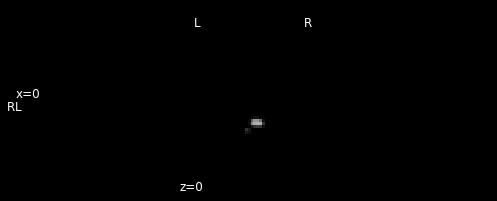

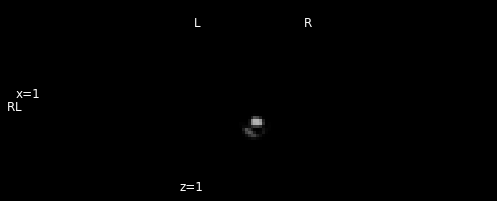

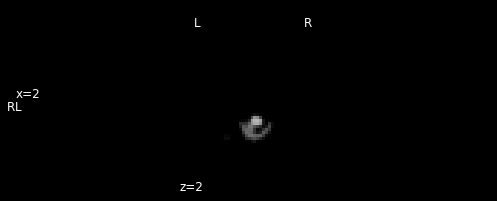

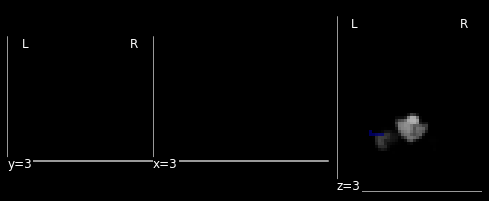

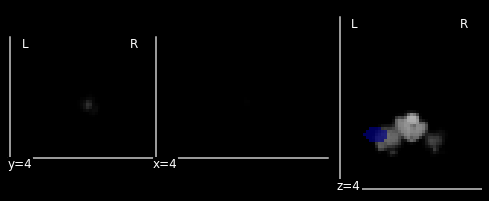

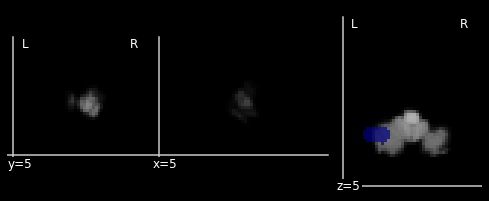

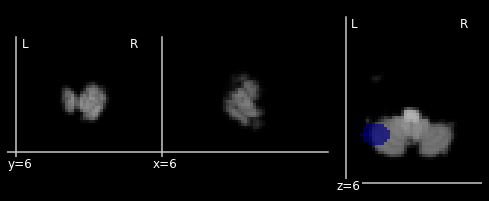

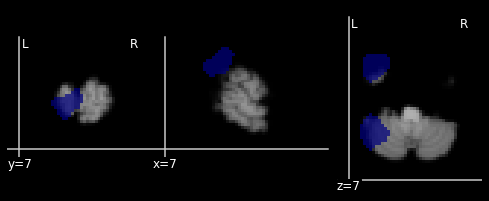

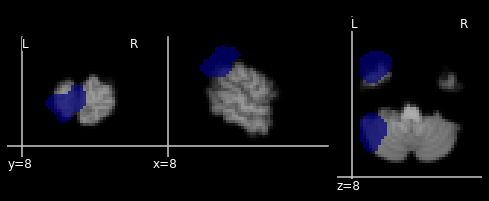

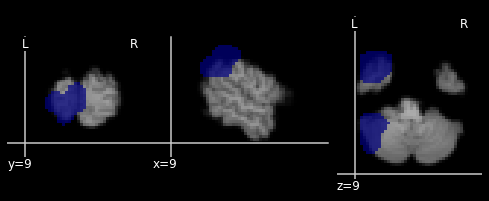

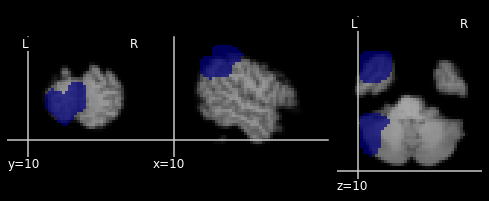

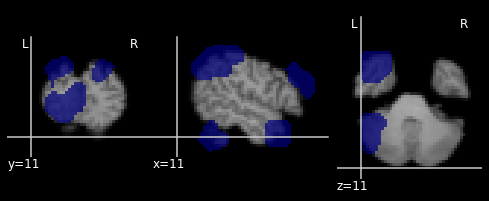

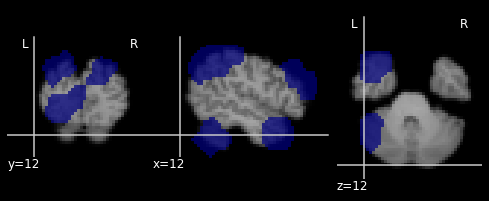

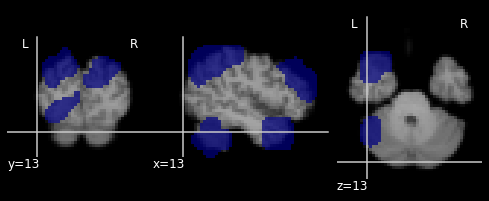

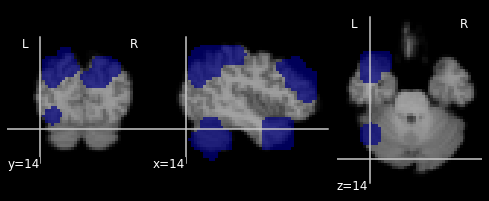

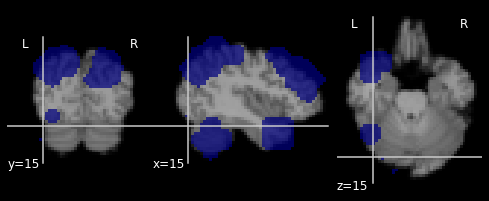

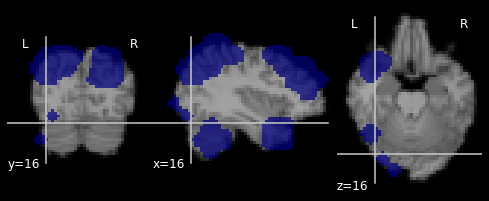

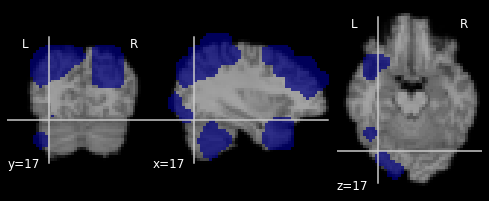

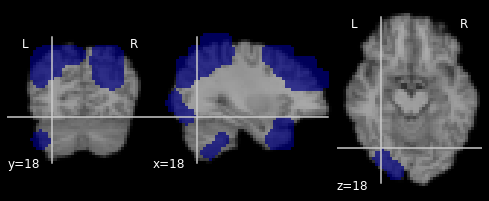

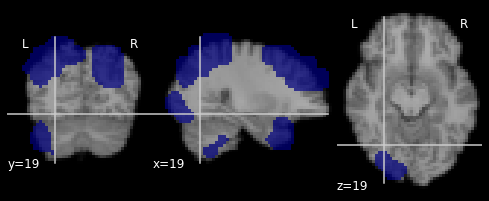

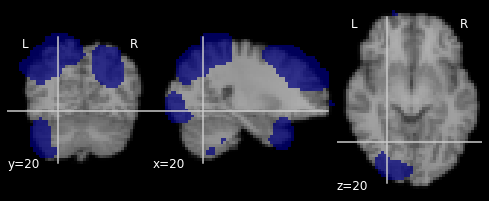

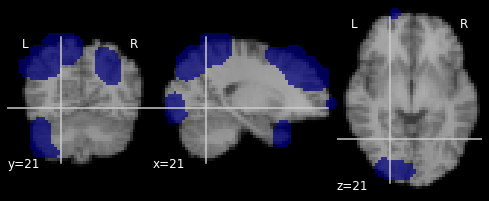

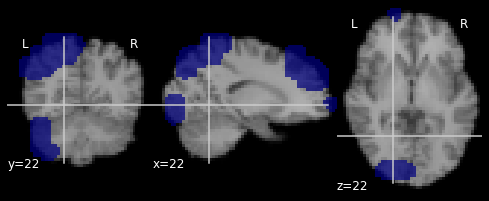

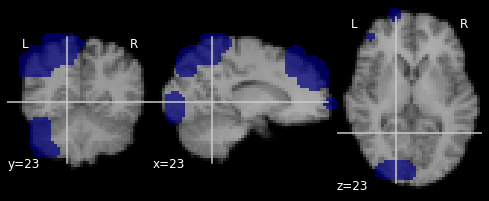

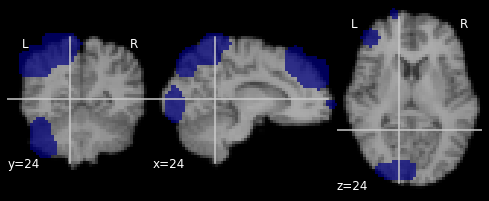

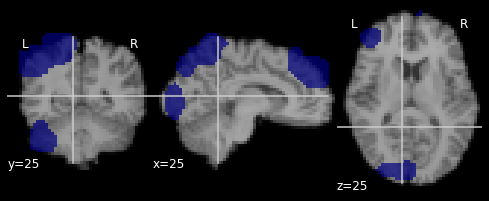

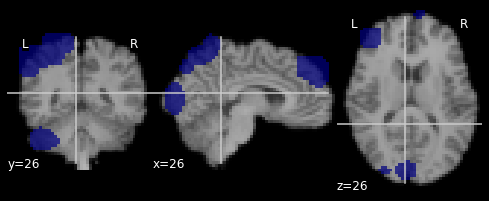

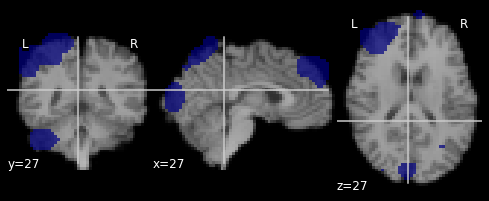

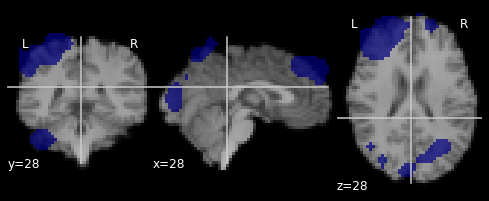

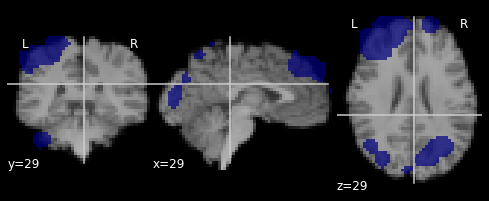

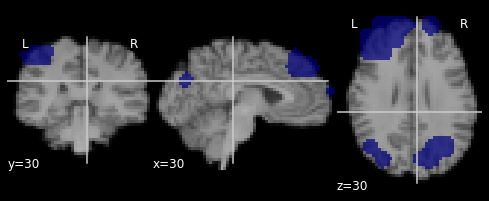

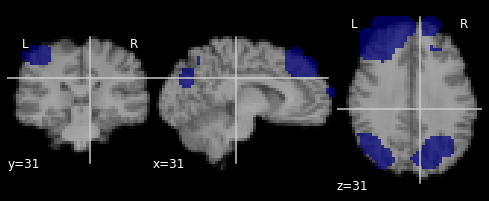

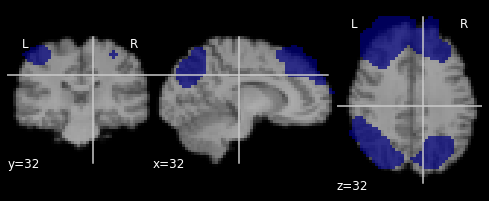

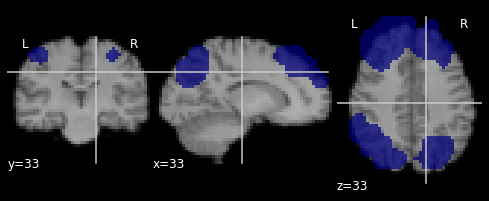

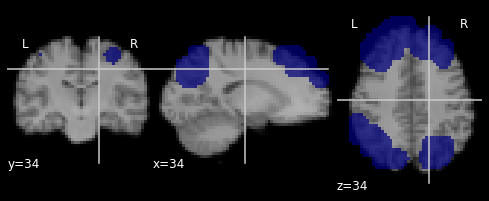

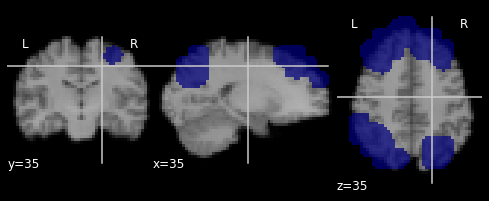

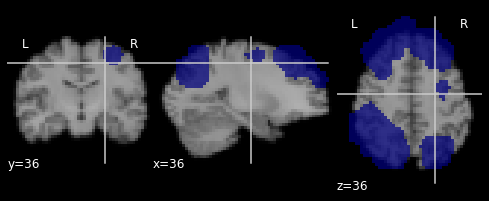

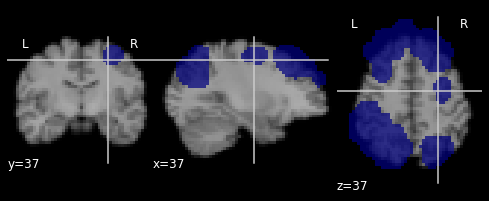

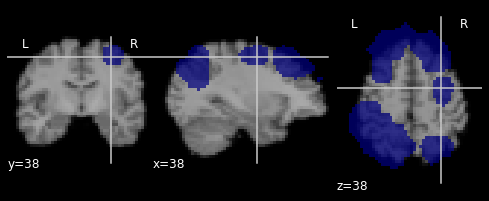

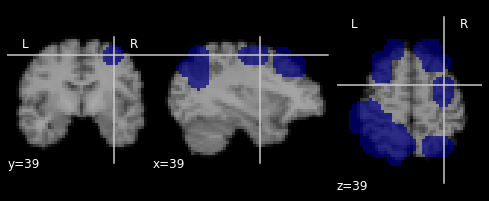

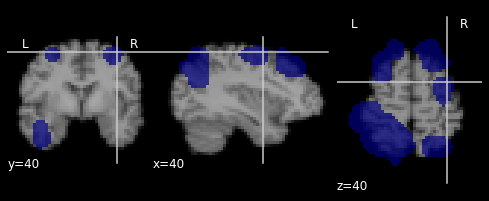

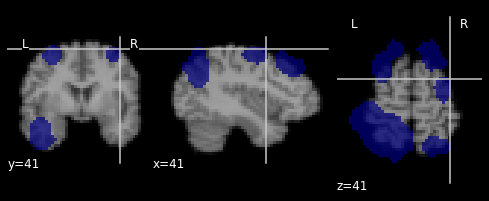

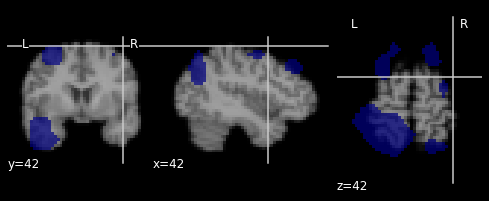

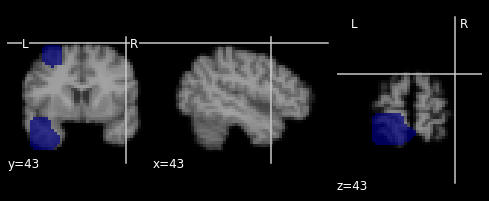

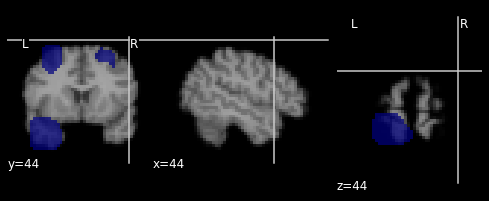

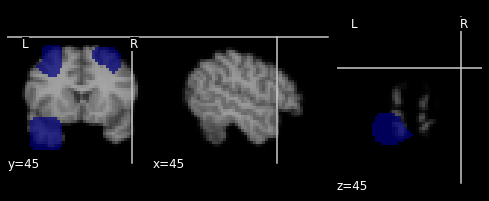

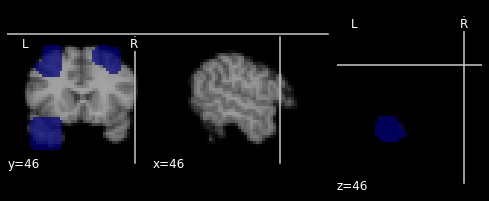

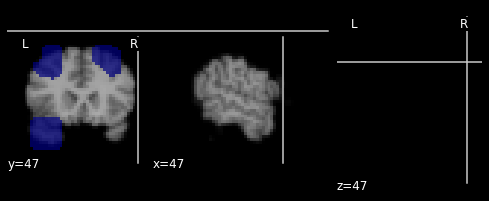

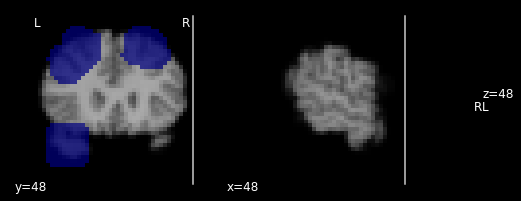

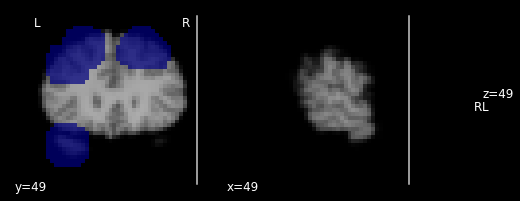

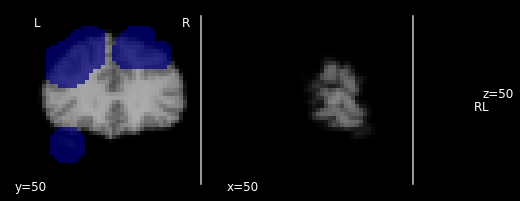

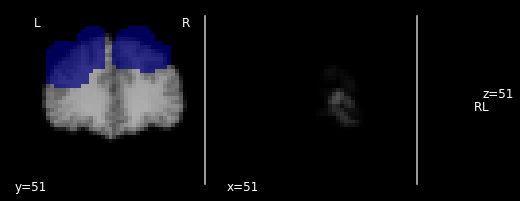

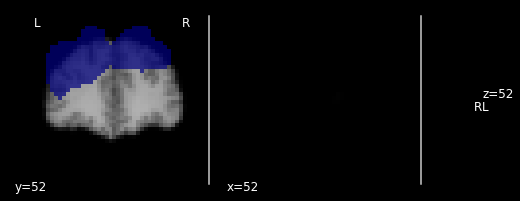

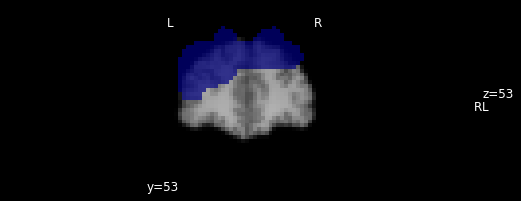

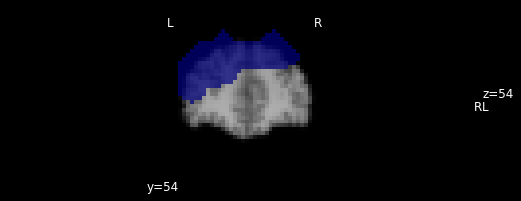

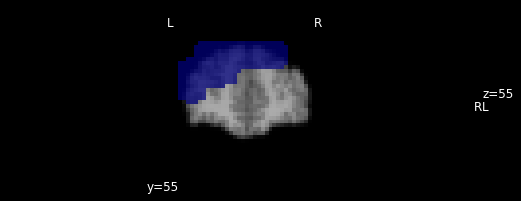

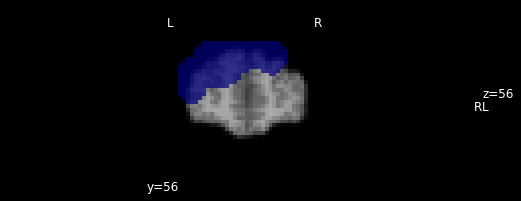

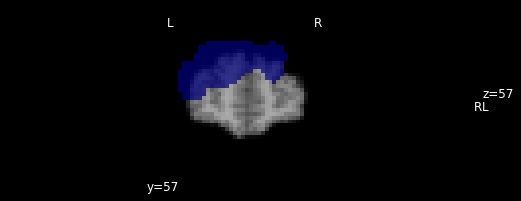

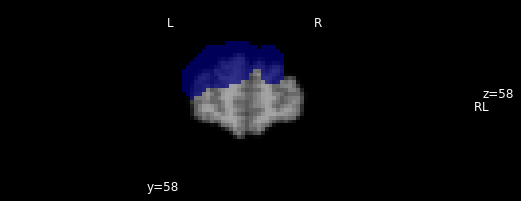

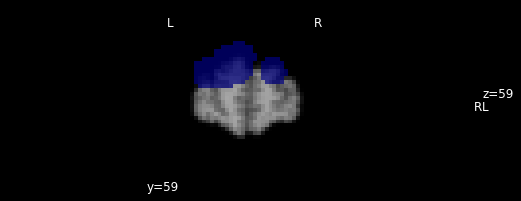

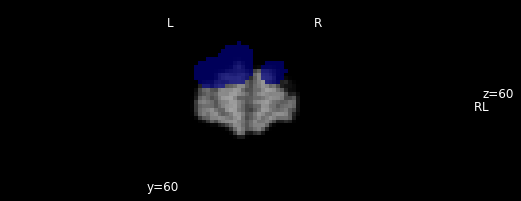

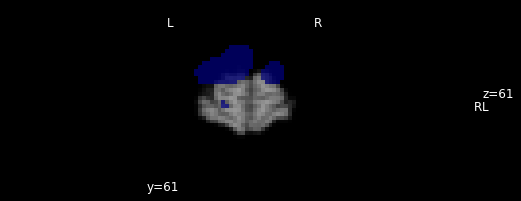

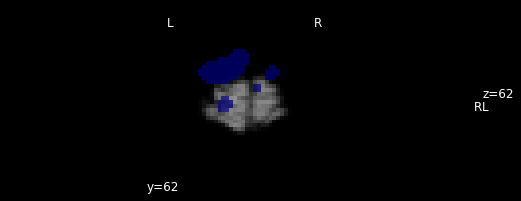

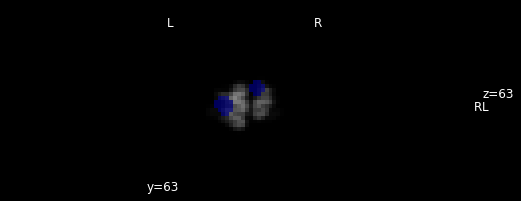

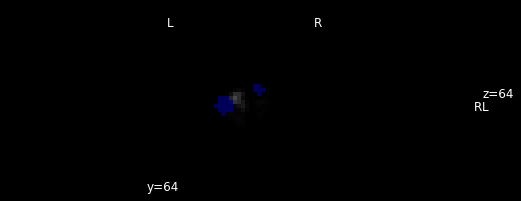

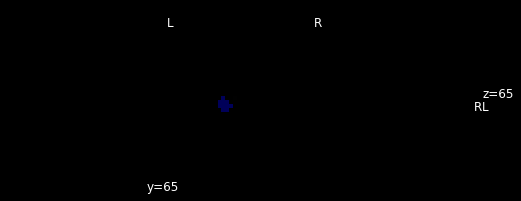

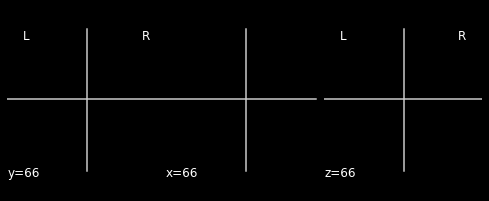

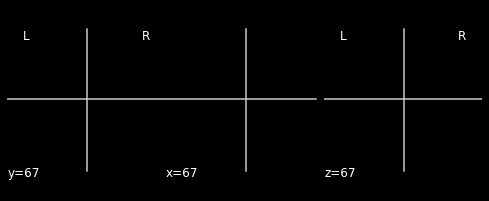

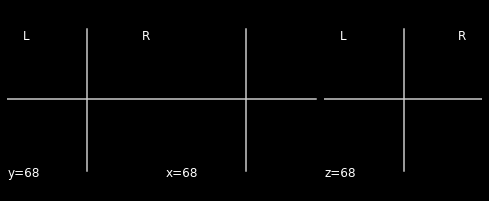

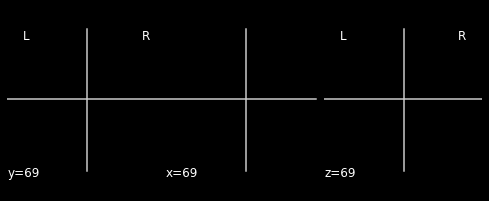

In [10]:
roi_img = nib.Nifti1Image( np.squeeze(tensors_mask[0]),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
for i in range(70):
    plotting.plot_roi(roi_img,bim_img,cut_coords=(i,i,i))
    plotting.show()

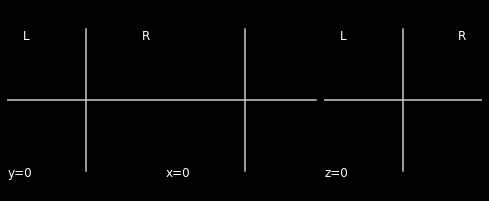

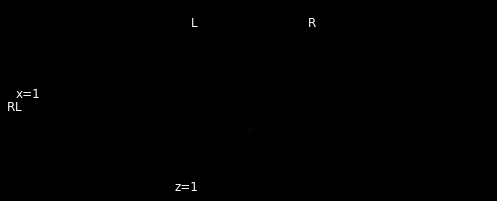

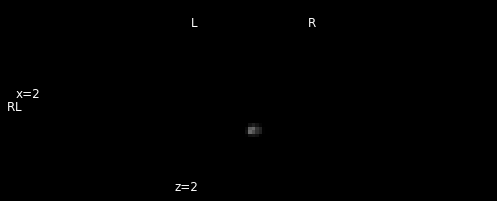

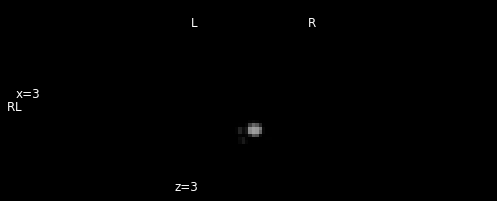

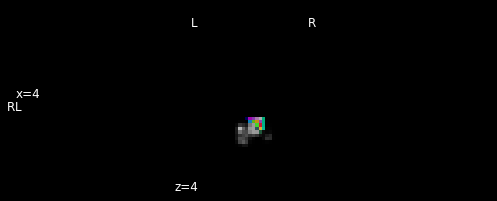

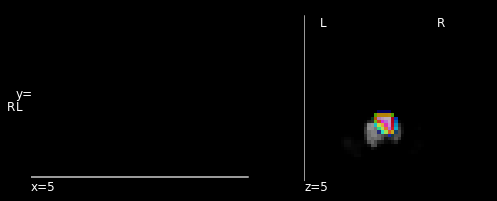

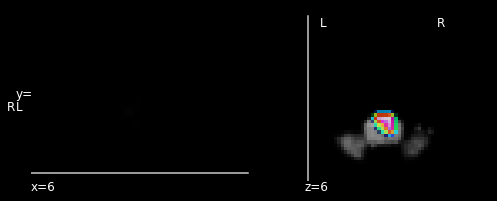

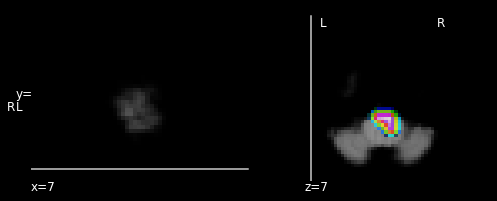

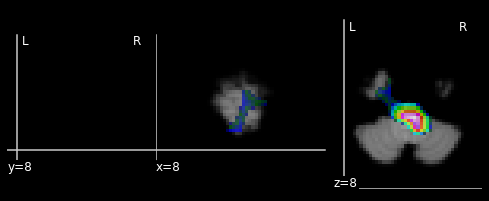

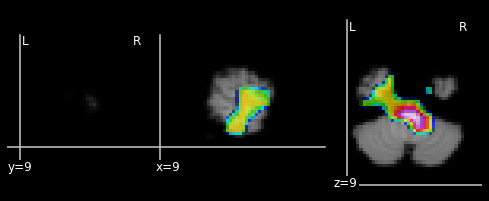

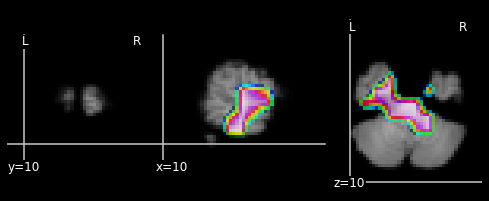

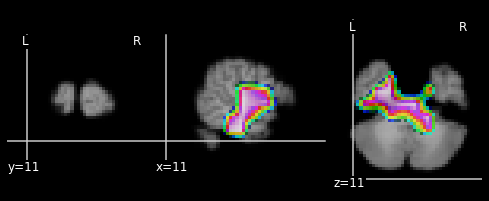

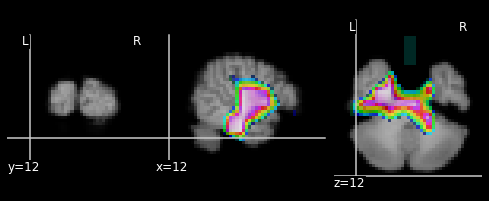

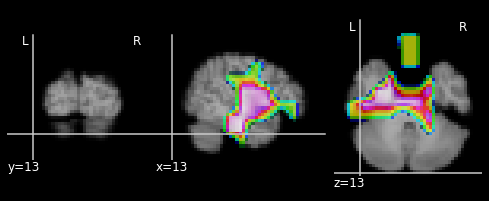

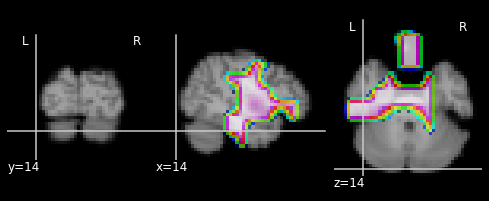

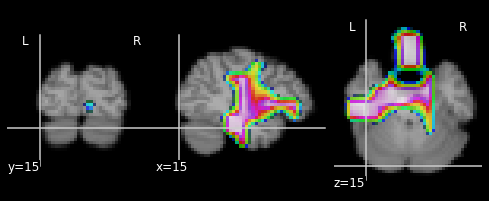

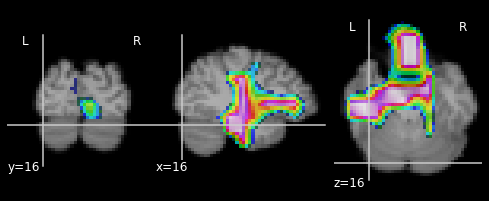

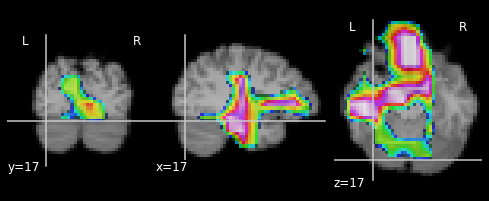

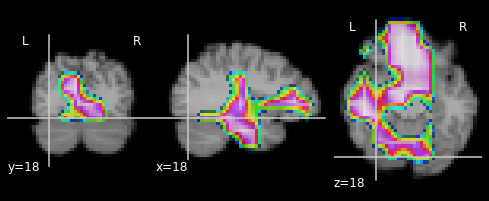

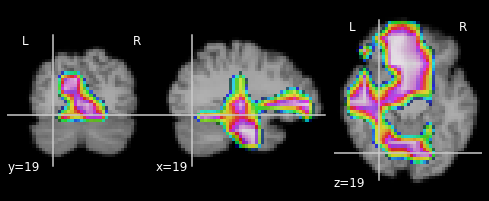

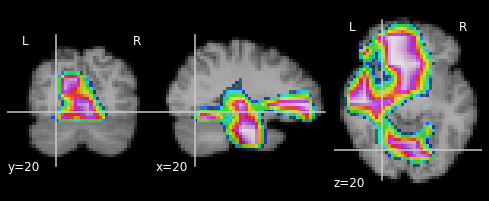

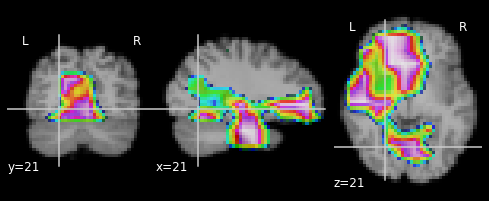

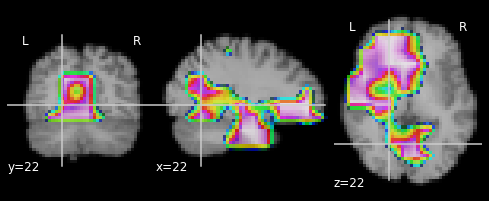

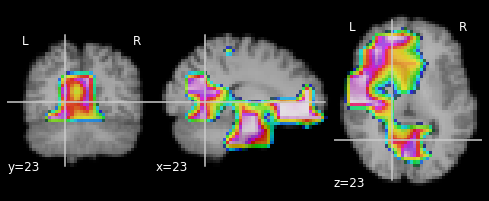

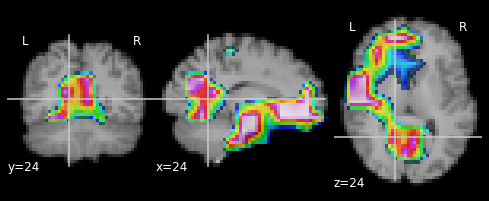

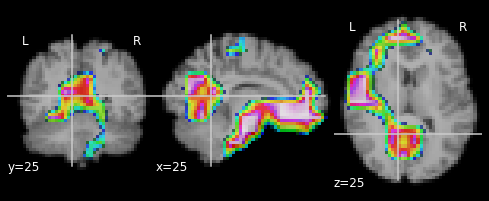

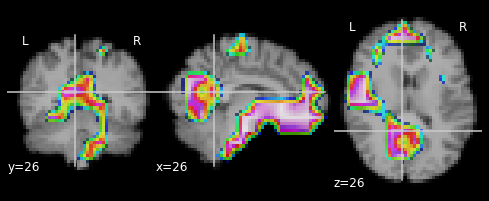

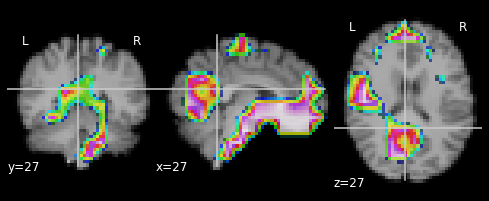

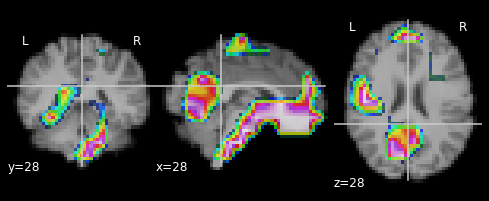

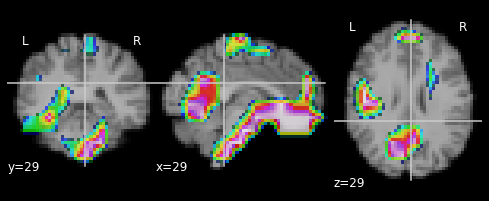

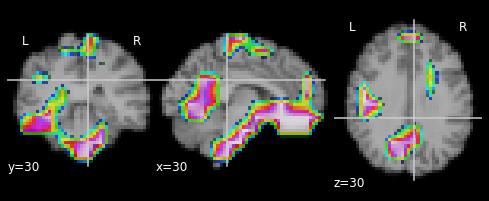

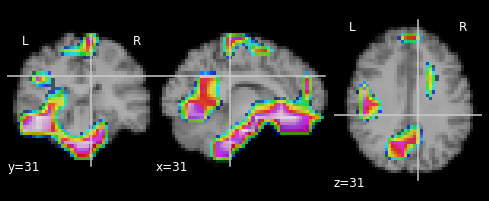

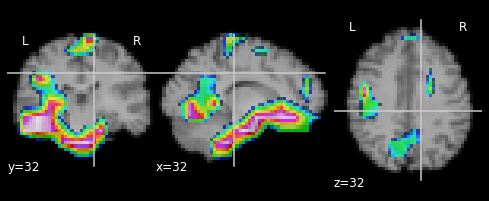

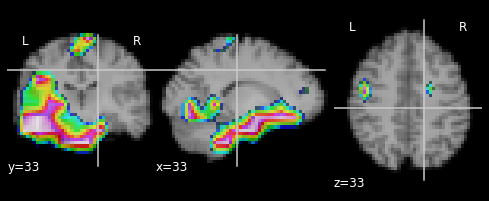

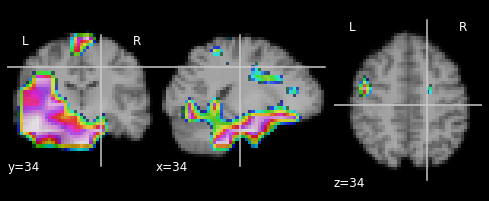

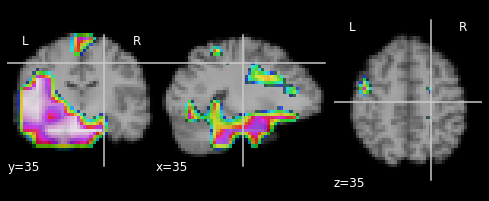

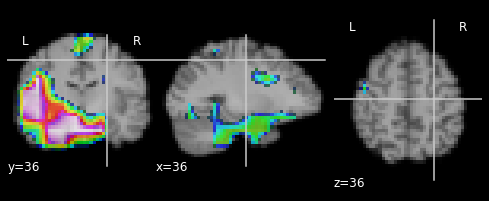

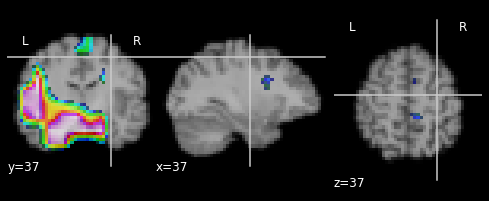

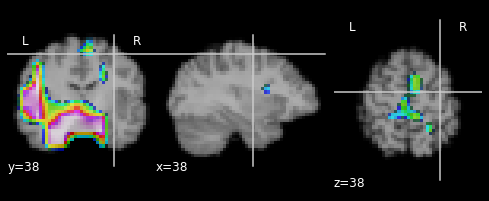

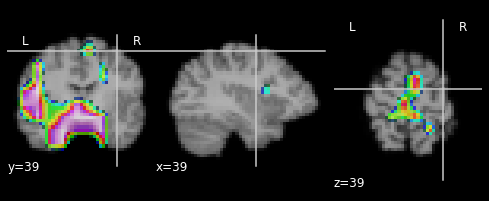

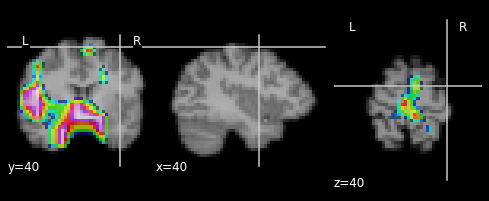

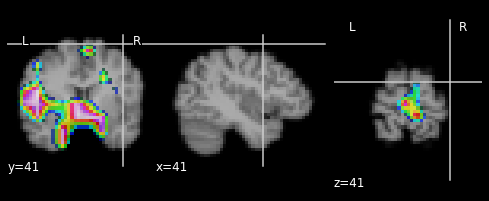

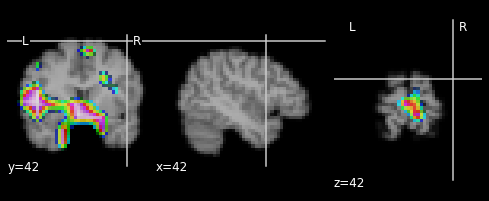

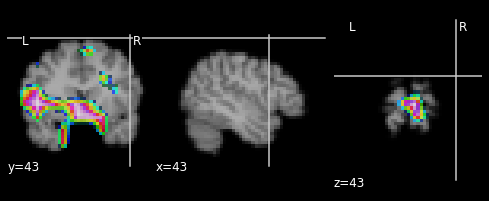

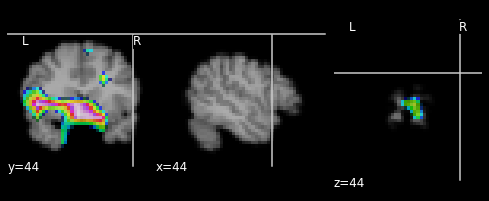

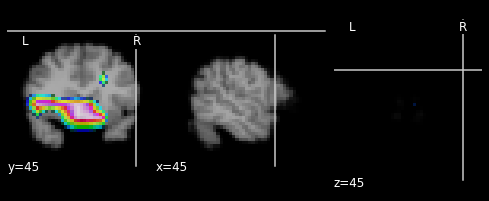

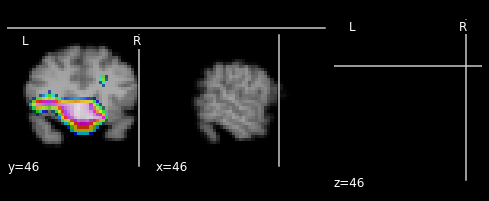

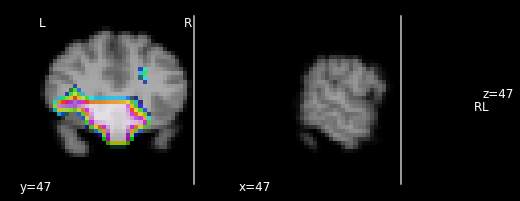

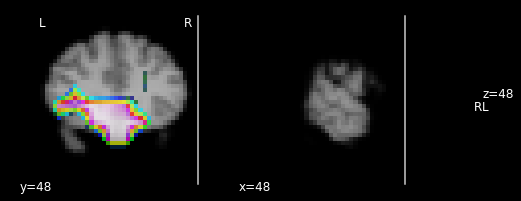

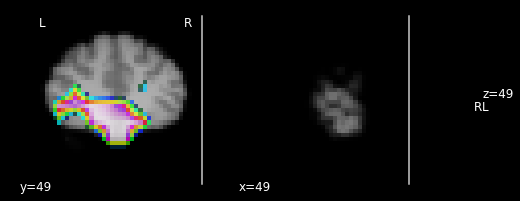

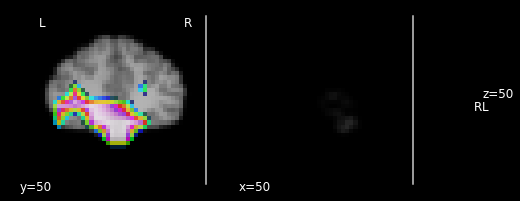

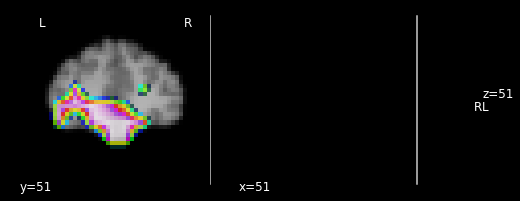

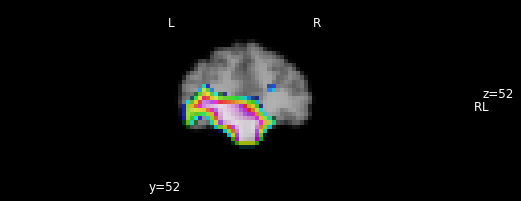

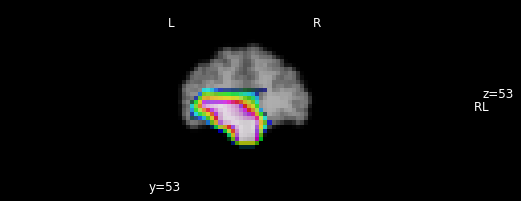

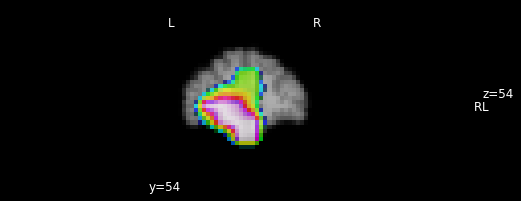

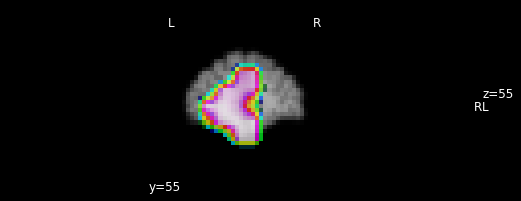

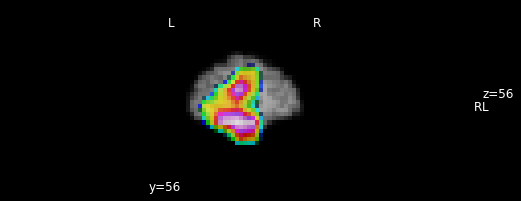

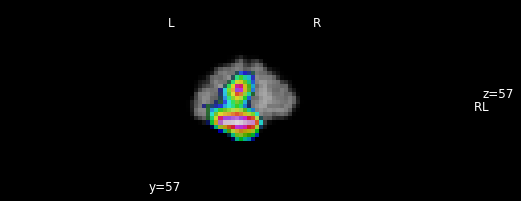

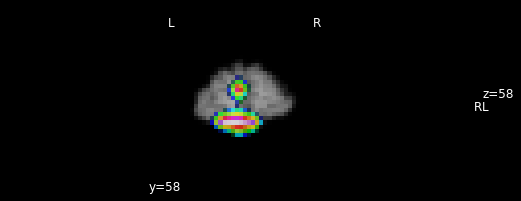

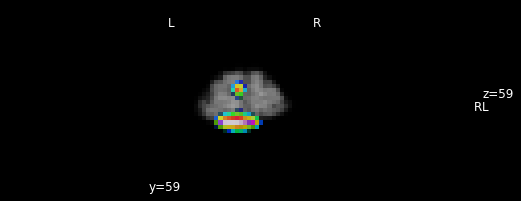

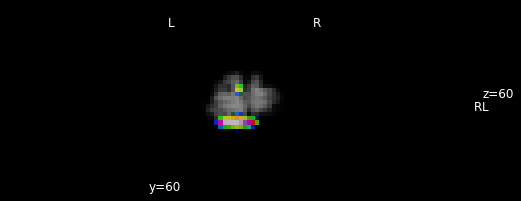

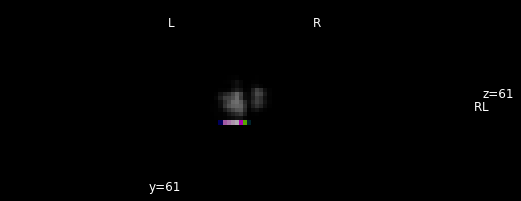

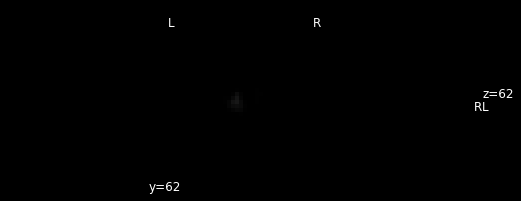

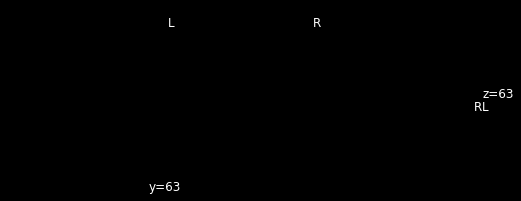

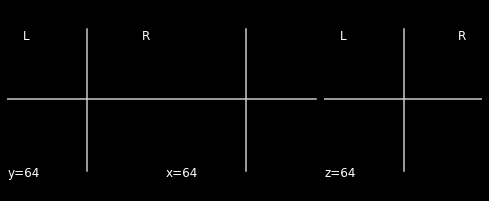

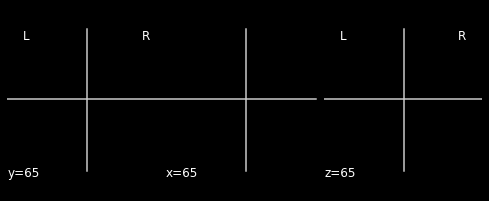

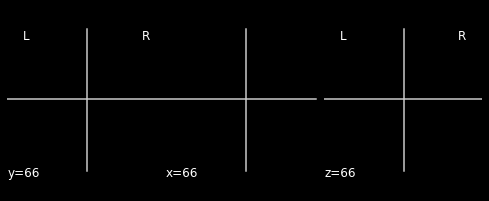

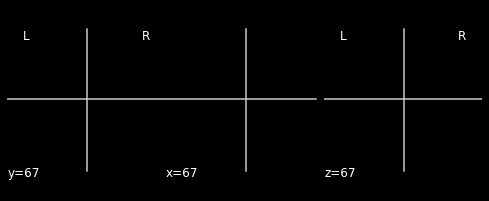

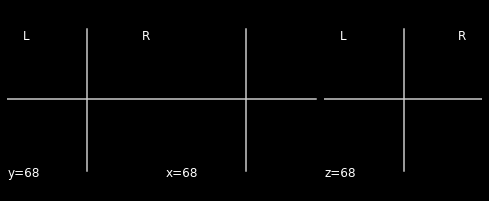

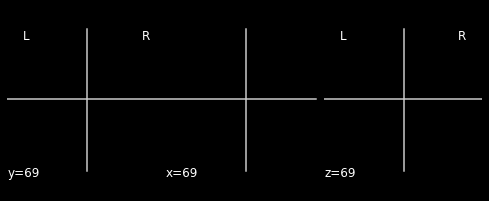

In [9]:
roi_img = nib.Nifti1Image( np.squeeze(tensors_mask[1]),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
for i in range(70):
    plotting.plot_roi(roi_img,bim_img,cut_coords=(i,i,i))
    plotting.show()

In [7]:
del net
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0
EPOCHS = 20
for train_index, test_index in skf.split(X, y):
    print('Doing {} split'.format(j))
    j += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_dataset = MriData(X_train, y_train)
    test_dataset = MriData(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 
    
    model = MriNet(c).to(device)
    criterion = nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

    train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader))
    del train_dataset, test_dataset,train_loader,val_loader,model,criterion,optimizer,scheduler


In [19]:
print('Average cross-validation accuracy (10-folds):', sum(cross_vall_acc_list)/len(cross_vall_acc_list))

0.9299191374663073

In [9]:
women = []
men = []
for i,img in enumerate(X):
    if y[i] == 0:
        women.append(np.count_nonzero(X[i])/np.count_nonzero(X[i]*tensors_mask[i]))
    else:
        men.append(np.count_nonzero(X[i])/np.count_nonzero(X[i]*tensors_mask[i]))
print('For men number of non zero voxel in new tensor {:.2} times less on average'.format(np.mean(men)))
print('For women number of non zero voxel in new tensor {:.2} times less on average'.format(np.mean(women)))

For men number of non zero voxel in new tensor 9.1 times less on average
For women number of non zero voxel in new tensor 3.5 times less on average
